In [12]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from numpy import loadtxt
import tensorflow.keras.backend as K

def read_tr(file_path, test_size=0.15, random_state=42):
    # load tr data
    train = loadtxt(file_path, delimiter=',', usecols=range(1, 14), dtype=np.float64)

    # Esclude la prima colonna e le ultime tre colonne (target)
    x = train[:, :-3]
    y = train[:, -3:]  # Le ultime tre colonne rappresentano i target

    # Suddivide il dataset in set di addestramento e test
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state)

    return x_train, y_train, x_test, y_test


def read_ts():
    file = "./cup/ds/ML-CUP23-TS.csv"
    test = loadtxt(file, delimiter=',', usecols=range(1, 11), dtype=np.float64)

    return test


def euclidean_distance_loss(y_true, y_pred):
    return np.sqrt(np.sum((y_pred - y_true) ** 2, axis=-1))

# it retrieves the mean value of all the passed losses
def euclidean_distance_score(y_true, y_pred):
    return np.mean(euclidean_distance_loss(y_true, y_pred))

scorer = make_scorer(euclidean_distance_score, greater_is_better=False)

def model_selection(x, y):
    # fix random seed for reproducibility
    seed = 42
    np.random.seed(seed)

    svr = SVR()
    model = MultiOutputRegressor(svr)

    # define the grid search parameters
    epsilon = np.arange(start=0.1, stop=0.9, step=0.01) #step 0.1
    epsilon = [float(round(i, 4)) for i in list(epsilon)]

    param_grid = [{'estimator__kernel': ['rbf'],
                   'estimator__gamma': [1e-1, 1e-2, 1e-3, 1e-4, 'auto', 'scale'],
                   'estimator__C': [5, 10, 15, 25],
                   'estimator__epsilon': epsilon}]

    start_time = time.time()
    print("Starting Grid Search...")

    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10,
                        return_train_score=True, scoring=scorer, verbose=1)

    grid_result = grid.fit(x, y)

    print("\nEnded Grid Search. ({:.4f})\n".format(time.time() - start_time))

    means_train = abs(grid_result.cv_results_['mean_train_score'])
    means_test = abs(grid_result.cv_results_['mean_test_score'])
    times_train = grid_result.cv_results_['mean_fit_time']
    times_test = grid_result.cv_results_['mean_score_time']
    params = grid_result.cv_results_['params']

    for m_ts, t_ts, m_tr, t_tr, p in sorted(zip(means_test, times_test, means_train, times_train, params)):
        print("{} \t TR {:.4f} (in {:.4f}) \t TS {:.4f} (in {:.4f})".format(p, m_tr, t_tr, m_ts, t_ts))

    print("\nBest: {:.4f} using {}\n".format(abs(grid.best_score_), grid_result.best_params_))

    return grid.best_params_


def predict(model, x_ts, x_its, y_its):
    # predict on internal test set
    iloss = K.eval(euclidean_distance_loss(y_its, model.predict(x_its)))
    # predict on blind test set
    y_pred = model.predict(x_ts)
    # return predicted target on blind test set,
    # and losses on internal test set
    return y_pred, iloss


def plot_learning_curve(model, x, y, savefig=False):

    # dictify model's parameters
    p = model.get_params()
    params = dict(kernel=p['estimator__kernel'], C=p['estimator__C'],
                  gamma=p['estimator__gamma'], eps=p['estimator__epsilon'])

    # plot learning curve by training and scoring the model for different train sizes
    train_sizes, train_scores_svr, test_scores_svr = \
        learning_curve(model, x, y, train_sizes=np.linspace(0.1, 1, 50),
                       n_jobs=-1, scoring=scorer, cv=10, verbose=1)

    plt.plot(train_sizes, np.mean(np.abs(train_scores_svr), axis=1))
    plt.plot(train_sizes, np.mean(np.abs(test_scores_svr), axis=1))
    plt.xlabel("Train size")
    plt.ylabel("Loss")
    plt.legend(['Loss TR', 'Loss VL'])
    plt.title(f'SVR Learning curve \n {params}')

    plt.show()


def sklearn_svm(ms=True):
    print("sklearn start")
    file_path="./cup/ds/ML-CUP23-TR.csv"

    # read training set
    x, y, x_its, y_its = read_tr(file_path)

    # choose model selection or hand-given parameters
    if ms:
        params = model_selection(x, y)
    else:
        params = dict(estimator__kernel='rbf', estimator__C=8, estimator__epsilon=0.6, estimator__gamma='scale')

    # create model and fit the model
    svr = SVR(kernel=params['estimator__kernel'], C=params['estimator__C'],
              gamma=params['estimator__gamma'], epsilon=params['estimator__epsilon'])

    # we use MOR to perform the multi-output regression task
    model = MultiOutputRegressor(svr)

    # split development set into train and test set
    x_tr, x_vl, y_tr, y_vl = train_test_split(x, y, test_size=0.3)
    model.fit(x_tr, y_tr)

    tr_losses = euclidean_distance_loss(y_tr, model.predict(x_tr))
    val_losses = euclidean_distance_loss(y_vl, model.predict(x_vl))

    y_pred, ts_losses = predict(model=model, x_ts=read_ts(), x_its=x_its, y_its=y_its)

    print("TR Loss: ", np.mean(tr_losses))
    print("VL Loss: ", np.mean(val_losses))
    print("TS Loss: ", np.mean(ts_losses))

    print("\nsklearn end")

    plot_learning_curve(model, x, y)
    


sklearn start
Starting Grid Search...
Fitting 10 folds for each of 1920 candidates, totalling 19200 fits



Ended Grid Search. (694.7635)

{'estimator__C': 25, 'estimator__epsilon': 0.1, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'} 	 TR 0.9100 (in 0.5050) 	 TS 1.1512 (in 0.0245)
{'estimator__C': 25, 'estimator__epsilon': 0.11, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'} 	 TR 0.9115 (in 0.4877) 	 TS 1.1518 (in 0.0257)
{'estimator__C': 25, 'estimator__epsilon': 0.12, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'} 	 TR 0.9129 (in 0.4853) 	 TS 1.1523 (in 0.0247)
{'estimator__C': 25, 'estimator__epsilon': 0.13, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'} 	 TR 0.9145 (in 0.4657) 	 TS 1.1526 (in 0.0226)
{'estimator__C': 25, 'estimator__epsilon': 0.14, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'} 	 TR 0.9163 (in 0.4564) 	 TS 1.1528 (in 0.0228)
{'estimator__C': 25, 'estimator__epsilon': 0.15, 'estimator__gamma': 'scale', 'estimator__kernel': 'rbf'} 	 TR 0.9182 (in 0.4493) 	 TS 1.1537 (in 0.0219)
{'estimator__C': 25, 'estimator__epsilon': 0.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   16.4s finished


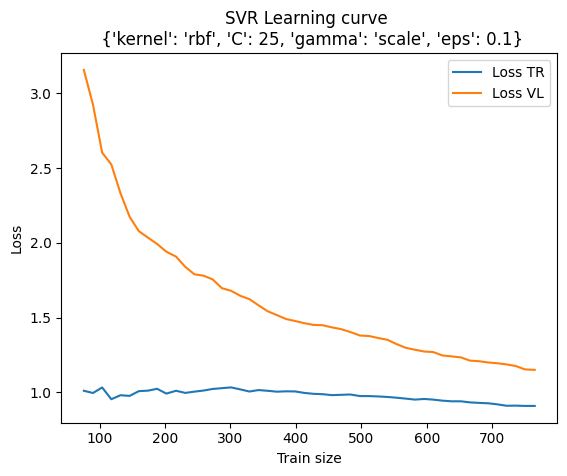

In [13]:
sklearn_svm()
# all it ttakes a fool to remain sane 